# Applying Custom CNN + SEBlock Attention Module On RSI-CB256 Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/satellite-image-classification/data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: green_area --> count: 1500
class: cloudy --> count: 1500
class: water --> count: 1500
class: desert --> count: 1131


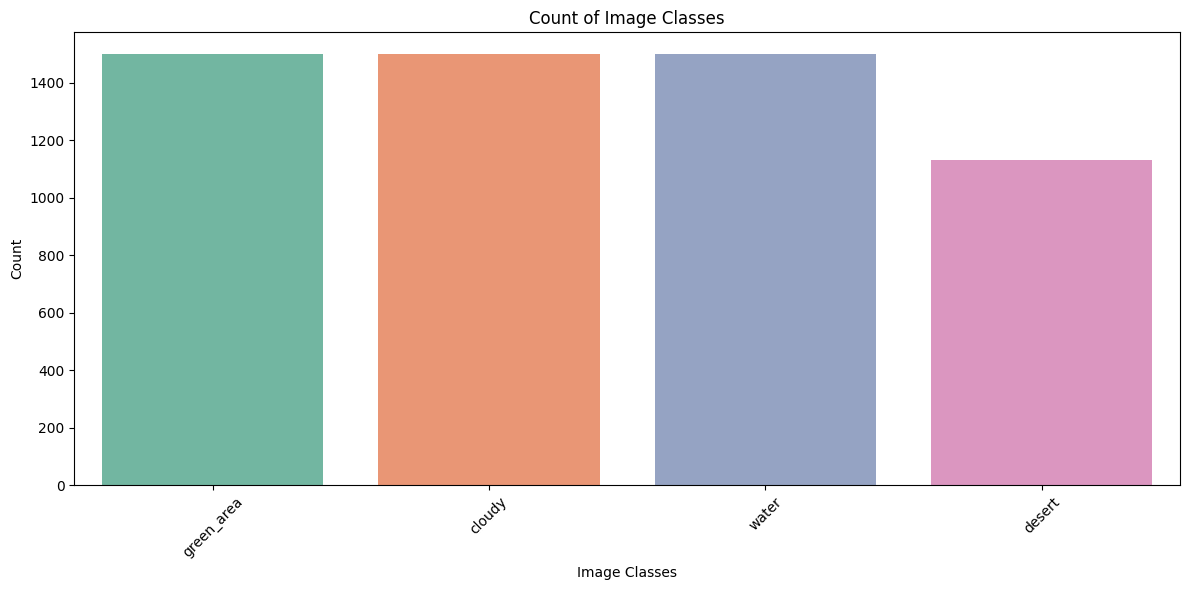

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

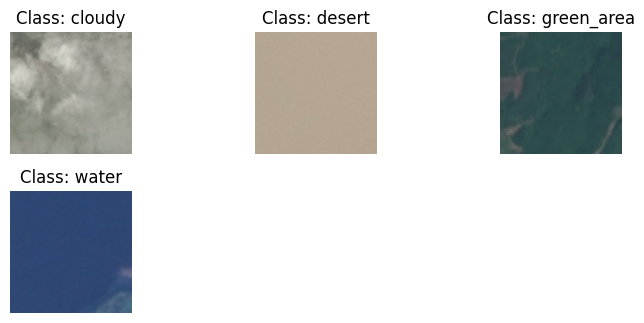

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  3941
Validation Data:  845
Test Data:  845
-------------------------------------------
Total amounts of data in the dataset:  5631


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class         Count
----------  -------
green_area     1050
cloudy         1050
water          1050
desert          791

Validation Dataset
Class         Count
----------  -------
cloudy          225
green_area      225
water           225
desert          170

Test Dataset
Class         Count
----------  -------
green_area      225
water           225
cloudy          225
desert          170


label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert('RGB')

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [16]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)       # [B, C]
        y = self.fc(y).view(b, c, 1, 1)              # [B, C, 1, 1]
        return x * y.expand_as(x)

### Convolutional Neural Netwirk (G7CNN)

In [17]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112
            
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56
            

            # Block 3
            nn.Conv2d(64, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 84 x 28 x 28
            SEBlock(84),

            # Block 4
            nn.Conv2d(84, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 14 x 14
            SEBlock(128),
            
            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 7 x 7
            SEBlock(256),

        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 256 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 256
            nn.Linear(256, 256),                 # → 256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [18]:
total_class = 4
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)
model.classifier[-1] = nn.Linear(256, total_class)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Training

In [19]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 62/62 [00:19<00:00,  3.18it/s, acc=0.81, loss=0.707] 

Training Loss: 0.707 Acc: 0.810


Validation Loss: 0.390 Acc: 0.907
✅ Best model saved at epoch 1 with validation accuracy: 0.907


Epoch 2/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.899, loss=0.326]

Training Loss: 0.326 Acc: 0.899


Validation Loss: 0.164 Acc: 0.976
✅ Best model saved at epoch 2 with validation accuracy: 0.976


Epoch 3/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.924, loss=0.234]

Training Loss: 0.234 Acc: 0.924


Validation Loss: 0.101 Acc: 0.970


Epoch 4/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.923, loss=0.227]

Training Loss: 0.227 Acc: 0.923


Validation Loss: 0.092 Acc: 0.975


Epoch 5/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.936, loss=0.19] 

Training Loss: 0.190 Acc: 0.936


Validation Loss: 0.080 Acc: 0.967


Epoch 6/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.949, loss=0.159]

Training Loss: 0.159 Acc: 0.949


Validation Loss: 0.061 Acc: 0.980
✅ Best model saved at epoch 6 with validation accuracy: 0.980


Epoch 7/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.945, loss=0.166]

Training Loss: 0.166 Acc: 0.945


Validation Loss: 0.067 Acc: 0.980


Epoch 8/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.95, loss=0.14]  

Training Loss: 0.140 Acc: 0.950


Validation Loss: 0.072 Acc: 0.976


Epoch 9/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.954, loss=0.128]

Training Loss: 0.128 Acc: 0.954


Validation Loss: 0.051 Acc: 0.985
✅ Best model saved at epoch 9 with validation accuracy: 0.985


Epoch 10/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.96, loss=0.126] 

Training Loss: 0.126 Acc: 0.960


Validation Loss: 0.069 Acc: 0.973


Epoch 11/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.943, loss=0.16] 

Training Loss: 0.160 Acc: 0.943


Validation Loss: 0.068 Acc: 0.986
✅ Best model saved at epoch 11 with validation accuracy: 0.986


Epoch 12/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.955, loss=0.126]

Training Loss: 0.126 Acc: 0.955


Validation Loss: 0.073 Acc: 0.978


Epoch 13/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.954, loss=0.128]

Training Loss: 0.128 Acc: 0.954


Validation Loss: 0.064 Acc: 0.985


Epoch 14/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.948, loss=0.143]

Training Loss: 0.143 Acc: 0.948


Validation Loss: 0.053 Acc: 0.980


Epoch 15/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.952, loss=0.128]

Training Loss: 0.128 Acc: 0.952


Validation Loss: 0.081 Acc: 0.969


Epoch 16/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.951, loss=0.129]

Training Loss: 0.129 Acc: 0.951


Validation Loss: 0.086 Acc: 0.966


Epoch 17/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.958, loss=0.123] 

Training Loss: 0.123 Acc: 0.958


Validation Loss: 0.045 Acc: 0.983


Epoch 18/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.956, loss=0.124] 

Training Loss: 0.124 Acc: 0.956


Validation Loss: 0.055 Acc: 0.987
✅ Best model saved at epoch 18 with validation accuracy: 0.987


Epoch 19/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.959, loss=0.117]

Training Loss: 0.117 Acc: 0.959


Validation Loss: 0.107 Acc: 0.955


Epoch 20/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.954, loss=0.126]

Training Loss: 0.126 Acc: 0.954


Validation Loss: 0.068 Acc: 0.981


Epoch 21/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.963, loss=0.101] 

Training Loss: 0.101 Acc: 0.963


Validation Loss: 0.045 Acc: 0.986


Epoch 22/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.964, loss=0.0999]

Training Loss: 0.100 Acc: 0.964


Validation Loss: 0.087 Acc: 0.981


Epoch 23/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.961, loss=0.109]

Training Loss: 0.109 Acc: 0.961


Validation Loss: 0.047 Acc: 0.979


Epoch 24/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.964, loss=0.0988]

Training Loss: 0.099 Acc: 0.964


Validation Loss: 0.039 Acc: 0.986


Epoch 25/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.958, loss=0.106] 

Training Loss: 0.106 Acc: 0.958


Validation Loss: 0.034 Acc: 0.992
✅ Best model saved at epoch 25 with validation accuracy: 0.992


Epoch 26/150: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s, acc=0.956, loss=0.118]

Training Loss: 0.118 Acc: 0.956


Validation Loss: 0.093 Acc: 0.967


Epoch 27/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.963, loss=0.102]

Training Loss: 0.102 Acc: 0.963


Validation Loss: 0.039 Acc: 0.987


Epoch 28/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.965, loss=0.0936]

Training Loss: 0.094 Acc: 0.965


Validation Loss: 0.046 Acc: 0.986


Epoch 29/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.971, loss=0.0818]

Training Loss: 0.082 Acc: 0.971


Validation Loss: 0.065 Acc: 0.978


Epoch 30/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.966, loss=0.0963]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.031 Acc: 0.989


Epoch 31/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.971, loss=0.0798]

Training Loss: 0.080 Acc: 0.971


Validation Loss: 0.038 Acc: 0.989


Epoch 32/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.965, loss=0.0871]

Training Loss: 0.087 Acc: 0.965


Validation Loss: 0.041 Acc: 0.988


Epoch 33/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.967, loss=0.0995]

Training Loss: 0.099 Acc: 0.967


Validation Loss: 0.030 Acc: 0.988


Epoch 34/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.973, loss=0.071] 

Training Loss: 0.071 Acc: 0.973


Validation Loss: 0.090 Acc: 0.962


Epoch 35/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.975, loss=0.0753]

Training Loss: 0.075 Acc: 0.975


Validation Loss: 0.036 Acc: 0.994
✅ Best model saved at epoch 35 with validation accuracy: 0.994


Epoch 36/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.968, loss=0.0928]

Training Loss: 0.093 Acc: 0.968


Validation Loss: 0.045 Acc: 0.982


Epoch 37/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.974, loss=0.079] 

Training Loss: 0.079 Acc: 0.974


Validation Loss: 0.033 Acc: 0.986


Epoch 38/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.968, loss=0.0827]

Training Loss: 0.083 Acc: 0.968


Validation Loss: 0.025 Acc: 0.993


Epoch 39/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.973, loss=0.0763]

Training Loss: 0.076 Acc: 0.973


Validation Loss: 0.030 Acc: 0.995
✅ Best model saved at epoch 39 with validation accuracy: 0.995


Epoch 40/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.968, loss=0.0853]

Training Loss: 0.085 Acc: 0.968


Validation Loss: 0.045 Acc: 0.988


Epoch 41/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.979, loss=0.0631]

Training Loss: 0.063 Acc: 0.979


Validation Loss: 0.041 Acc: 0.982


Epoch 42/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.973, loss=0.0774]

Training Loss: 0.077 Acc: 0.973


Validation Loss: 0.034 Acc: 0.991


Epoch 43/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.976, loss=0.0676]

Training Loss: 0.068 Acc: 0.976


Validation Loss: 0.034 Acc: 0.992


Epoch 44/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.975, loss=0.0644]

Training Loss: 0.064 Acc: 0.975


Validation Loss: 0.039 Acc: 0.988


Epoch 45/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.978, loss=0.0626]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.015 Acc: 0.995


Epoch 46/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.978, loss=0.0612]

Training Loss: 0.061 Acc: 0.978


Validation Loss: 0.030 Acc: 0.991


Epoch 47/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.981, loss=0.0511]

Training Loss: 0.051 Acc: 0.981


Validation Loss: 0.010 Acc: 0.996
✅ Best model saved at epoch 47 with validation accuracy: 0.996


Epoch 48/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.979, loss=0.0583]

Training Loss: 0.058 Acc: 0.979


Validation Loss: 0.023 Acc: 0.992


Epoch 49/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.976, loss=0.0615]

Training Loss: 0.062 Acc: 0.976


Validation Loss: 0.033 Acc: 0.988


Epoch 50/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.979, loss=0.0551]

Training Loss: 0.055 Acc: 0.979


Validation Loss: 0.030 Acc: 0.993


Epoch 51/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.985, loss=0.0475]

Training Loss: 0.048 Acc: 0.985


Validation Loss: 0.042 Acc: 0.988


Epoch 52/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.981, loss=0.0502]

Training Loss: 0.050 Acc: 0.981


Validation Loss: 0.021 Acc: 0.994


Epoch 53/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.986, loss=0.0386]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.020 Acc: 0.993


Epoch 54/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.983, loss=0.0479]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.019 Acc: 0.996


Epoch 55/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.987, loss=0.0373]

Training Loss: 0.037 Acc: 0.987


Validation Loss: 0.021 Acc: 0.991


Epoch 56/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.988, loss=0.0398]

Training Loss: 0.040 Acc: 0.988


Validation Loss: 0.019 Acc: 0.993


Epoch 57/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.985, loss=0.036] 

Training Loss: 0.036 Acc: 0.985


Validation Loss: 0.014 Acc: 0.995


Epoch 58/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.99, loss=0.0304] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.009 Acc: 0.996


Epoch 59/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.986, loss=0.0388]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.013 Acc: 0.995


Epoch 60/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.99, loss=0.031]  

Training Loss: 0.031 Acc: 0.990


Validation Loss: 0.012 Acc: 0.995


Epoch 61/150: 100%|██████████| 62/62 [00:12<00:00,  4.77it/s, acc=0.986, loss=0.0337]

Training Loss: 0.034 Acc: 0.986


Validation Loss: 0.050 Acc: 0.978


Epoch 62/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.989, loss=0.0291]

Training Loss: 0.029 Acc: 0.989


Validation Loss: 0.011 Acc: 0.996


Epoch 63/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.992, loss=0.023] 

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.022 Acc: 0.988


Epoch 64/150: 100%|██████████| 62/62 [00:12<00:00,  4.78it/s, acc=0.982, loss=0.0479]

Training Loss: 0.048 Acc: 0.982


Validation Loss: 0.031 Acc: 0.993


Epoch 65/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.99, loss=0.0298] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.008 Acc: 0.998
✅ Best model saved at epoch 65 with validation accuracy: 0.998


Epoch 66/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.988, loss=0.0396]

Training Loss: 0.040 Acc: 0.988


Validation Loss: 0.033 Acc: 0.989


Epoch 67/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.987, loss=0.0356]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.007 Acc: 0.998


Epoch 68/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.989, loss=0.0349]

Training Loss: 0.035 Acc: 0.989


Validation Loss: 0.129 Acc: 0.951


Epoch 69/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.991, loss=0.0258]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.009 Acc: 0.998


Epoch 70/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.991, loss=0.0247]

Training Loss: 0.025 Acc: 0.991


Validation Loss: 0.014 Acc: 0.995


Epoch 71/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.993, loss=0.0242]

Training Loss: 0.024 Acc: 0.993


Validation Loss: 0.008 Acc: 0.998


Epoch 72/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.991, loss=0.0259]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.010 Acc: 0.996


Epoch 73/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.991, loss=0.0286]

Training Loss: 0.029 Acc: 0.991


Validation Loss: 0.009 Acc: 0.996


Epoch 74/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.99, loss=0.0275] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.015 Acc: 0.994


Epoch 75/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.987, loss=0.0352]

Training Loss: 0.035 Acc: 0.987


Validation Loss: 0.011 Acc: 0.995


Epoch 76/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.992, loss=0.0235]

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.024 Acc: 0.993


Epoch 77/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.989, loss=0.0326]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.025 Acc: 0.994


Epoch 78/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.994, loss=0.0182]

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.011 Acc: 0.995


Epoch 79/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.989, loss=0.0304]

Training Loss: 0.030 Acc: 0.989


Validation Loss: 0.014 Acc: 0.994


Epoch 80/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.992, loss=0.0267]

Training Loss: 0.027 Acc: 0.992


Validation Loss: 0.018 Acc: 0.994


Epoch 81/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.991, loss=0.0281]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.014 Acc: 0.995


Epoch 82/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.994, loss=0.0195]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.013 Acc: 0.996


Epoch 83/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.994, loss=0.0187]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.015 Acc: 0.994


Epoch 84/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.992, loss=0.0248]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.015 Acc: 0.994


Epoch 85/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.991, loss=0.0228]

Training Loss: 0.023 Acc: 0.991


Validation Loss: 0.007 Acc: 0.996


Epoch 86/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.992, loss=0.0278]

Training Loss: 0.028 Acc: 0.992


Validation Loss: 0.010 Acc: 0.994


Epoch 87/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.993, loss=0.0224]

Training Loss: 0.022 Acc: 0.993


Validation Loss: 0.006 Acc: 0.998


Epoch 88/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.994, loss=0.0177]

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.007 Acc: 0.996


Epoch 89/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.993, loss=0.0192]

Training Loss: 0.019 Acc: 0.993


Validation Loss: 0.004 Acc: 0.999
✅ Best model saved at epoch 89 with validation accuracy: 0.999


Epoch 90/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.995, loss=0.0182]

Training Loss: 0.018 Acc: 0.995


Validation Loss: 0.074 Acc: 0.972


Epoch 91/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.989, loss=0.0317]

Training Loss: 0.032 Acc: 0.989


Validation Loss: 0.017 Acc: 0.995


Epoch 92/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.989, loss=0.0271]

Training Loss: 0.027 Acc: 0.989


Validation Loss: 0.005 Acc: 0.998


Epoch 93/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.994, loss=0.017] 

Training Loss: 0.017 Acc: 0.994


Validation Loss: 0.005 Acc: 0.999


Epoch 94/150: 100%|██████████| 62/62 [00:12<00:00,  4.78it/s, acc=0.993, loss=0.0186]

Training Loss: 0.019 Acc: 0.993


Validation Loss: 0.003 Acc: 0.999


Epoch 95/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.995, loss=0.0145]

Training Loss: 0.014 Acc: 0.995


Validation Loss: 0.010 Acc: 0.996


Epoch 96/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.992, loss=0.0247]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.048 Acc: 0.983


Epoch 97/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.993, loss=0.0184]

Training Loss: 0.018 Acc: 0.993


Validation Loss: 0.008 Acc: 0.998


Epoch 98/150: 100%|██████████| 62/62 [00:12<00:00,  4.78it/s, acc=0.994, loss=0.0194]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.010 Acc: 0.998


Epoch 99/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.991, loss=0.0232]

Training Loss: 0.023 Acc: 0.991


Validation Loss: 0.007 Acc: 0.999


Epoch 100/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.994, loss=0.0148]

Training Loss: 0.015 Acc: 0.994


Validation Loss: 0.007 Acc: 0.998


Epoch 101/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.995, loss=0.0152] 

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.003 Acc: 0.999


Epoch 102/150: 100%|██████████| 62/62 [00:12<00:00,  4.78it/s, acc=0.992, loss=0.0228]

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.019 Acc: 0.992


Epoch 103/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.991, loss=0.0264]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.012 Acc: 0.993


Epoch 104/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.995, loss=0.0146] 

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.016 Acc: 0.994


Epoch 105/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.996, loss=0.016]  

Training Loss: 0.016 Acc: 0.996


Validation Loss: 0.004 Acc: 0.998


Epoch 106/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.994, loss=0.0194] 

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.062 Acc: 0.979


Epoch 107/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.993, loss=0.0172]

Training Loss: 0.017 Acc: 0.993


Validation Loss: 0.004 Acc: 0.999


Epoch 108/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.992, loss=0.0244]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.007 Acc: 0.996


Epoch 109/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.993, loss=0.0198]

Training Loss: 0.020 Acc: 0.993


Validation Loss: 0.006 Acc: 0.998


Epoch 110/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.995, loss=0.0154] 

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.003 Acc: 0.999


Epoch 111/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.995, loss=0.0126] 

Training Loss: 0.013 Acc: 0.995


Validation Loss: 0.021 Acc: 0.993


Epoch 112/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.991, loss=0.0238]

Training Loss: 0.024 Acc: 0.991


Validation Loss: 0.005 Acc: 0.999


Epoch 113/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.994, loss=0.0148]

Training Loss: 0.015 Acc: 0.994


Validation Loss: 0.004 Acc: 0.999


Epoch 114/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.996, loss=0.0121] 

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.006 Acc: 0.998


Epoch 115/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.992, loss=0.0209] 

Training Loss: 0.021 Acc: 0.992


Validation Loss: 0.007 Acc: 0.998


Epoch 116/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.996, loss=0.012] 

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.003 Acc: 0.998


Epoch 117/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.995, loss=0.0133]

Training Loss: 0.013 Acc: 0.995


Validation Loss: 0.003 Acc: 0.999


Epoch 118/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.994, loss=0.0133] 

Training Loss: 0.013 Acc: 0.994


Validation Loss: 0.008 Acc: 0.998


Epoch 119/150: 100%|██████████| 62/62 [00:13<00:00,  4.74it/s, acc=0.996, loss=0.0119] 

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.004 Acc: 0.999


Epoch 120/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.996, loss=0.0106] 

Training Loss: 0.011 Acc: 0.996


Validation Loss: 0.003 Acc: 1.000
✅ Best model saved at epoch 120 with validation accuracy: 1.000


Epoch 121/150: 100%|██████████| 62/62 [00:13<00:00,  4.74it/s, acc=0.997, loss=0.00903]

Training Loss: 0.009 Acc: 0.997


Validation Loss: 0.004 Acc: 0.998


Epoch 122/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.994, loss=0.0141]

Training Loss: 0.014 Acc: 0.994


Validation Loss: 0.004 Acc: 0.999


Epoch 123/150: 100%|██████████| 62/62 [00:13<00:00,  4.75it/s, acc=0.992, loss=0.0216]

Training Loss: 0.022 Acc: 0.992


Validation Loss: 0.002 Acc: 1.000


Epoch 124/150: 100%|██████████| 62/62 [00:12<00:00,  4.79it/s, acc=0.983, loss=0.053] 

Training Loss: 0.053 Acc: 0.983


Validation Loss: 0.012 Acc: 0.995


Epoch 125/150: 100%|██████████| 62/62 [00:13<00:00,  4.75it/s, acc=0.994, loss=0.0181]

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.013 Acc: 0.993


Epoch 126/150: 100%|██████████| 62/62 [00:13<00:00,  4.77it/s, acc=0.995, loss=0.0175]

Training Loss: 0.017 Acc: 0.995


Validation Loss: 0.002 Acc: 0.999


Epoch 127/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.995, loss=0.0145] 

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.002 Acc: 0.999


Epoch 128/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.996, loss=0.0133]

Training Loss: 0.013 Acc: 0.996


Validation Loss: 0.003 Acc: 0.999


Epoch 129/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.996, loss=0.0113]

Training Loss: 0.011 Acc: 0.996


Validation Loss: 0.002 Acc: 0.999


Epoch 130/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.998, loss=0.00798]

Training Loss: 0.008 Acc: 0.998


Validation Loss: 0.006 Acc: 0.999


Epoch 131/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.996, loss=0.0108] 

Training Loss: 0.011 Acc: 0.996


Validation Loss: 0.001 Acc: 1.000


Epoch 132/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.998, loss=0.00727]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.001 Acc: 1.000


Epoch 133/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.993, loss=0.0173]

Training Loss: 0.017 Acc: 0.993


Validation Loss: 0.002 Acc: 0.999


Epoch 134/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.998, loss=0.00707]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.001 Acc: 0.999


Epoch 135/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.998, loss=0.00749]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.001 Acc: 1.000


Epoch 136/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.994, loss=0.0173]

Training Loss: 0.017 Acc: 0.994


Validation Loss: 0.003 Acc: 1.000


Epoch 137/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.994, loss=0.0148]

Training Loss: 0.015 Acc: 0.994


Validation Loss: 0.002 Acc: 0.999


Epoch 138/150: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s, acc=0.995, loss=0.0141]

Training Loss: 0.014 Acc: 0.995


Validation Loss: 0.006 Acc: 0.996


Epoch 139/150: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s, acc=0.997, loss=0.0105]

Training Loss: 0.010 Acc: 0.997


Validation Loss: 0.003 Acc: 0.999


Epoch 140/150: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s, acc=0.996, loss=0.00977]

Training Loss: 0.010 Acc: 0.996


Validation Loss: 0.009 Acc: 0.998


Epoch 141/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.995, loss=0.0146]

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.001 Acc: 1.000


Epoch 142/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.995, loss=0.014] 

Training Loss: 0.014 Acc: 0.995


Validation Loss: 0.002 Acc: 1.000


Epoch 143/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.997, loss=0.0109] 

Training Loss: 0.011 Acc: 0.997


Validation Loss: 0.014 Acc: 0.995


Epoch 144/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.998, loss=0.00691]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.016 Acc: 0.993


Epoch 145/150: 100%|██████████| 62/62 [00:12<00:00,  4.82it/s, acc=0.996, loss=0.0116] 

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.002 Acc: 0.999


Epoch 146/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.997, loss=0.00683]

Training Loss: 0.007 Acc: 0.997


Validation Loss: 0.002 Acc: 0.999


Epoch 147/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.998, loss=0.00471]

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.003 Acc: 0.999


Epoch 148/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.997, loss=0.0112] 

Training Loss: 0.011 Acc: 0.997


Validation Loss: 0.003 Acc: 0.999


Epoch 149/150: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s, acc=0.996, loss=0.0112] 

Training Loss: 0.011 Acc: 0.996


Validation Loss: 0.001 Acc: 1.000


Epoch 150/150: 100%|██████████| 62/62 [00:12<00:00,  4.80it/s, acc=0.996, loss=0.0132] 

Training Loss: 0.013 Acc: 0.996


Validation Loss: 0.007 Acc: 0.998
Training Time: 2162.35 seconds ---> 36.04 minutes


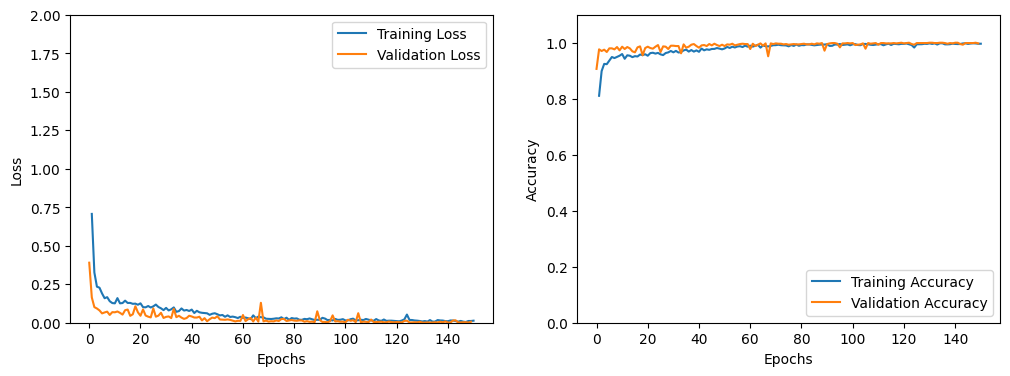

In [26]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [27]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 120) - Validation Loss: 0.003, Validation Accuracy: 1.000


In [28]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.999
Test Time: 1.37 seconds ---> 0.02 minutes


### Class Accuracy

In [29]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       1.00      1.00      1.00       170
           2       1.00      1.00      1.00       225
           3       1.00      1.00      1.00       225

    accuracy                           1.00       845
   macro avg       1.00      1.00      1.00       845
weighted avg       1.00      1.00      1.00       845

Class 0 Accuracy: 1.000
Class 1 Accuracy: 1.000
Class 2 Accuracy: 1.000
Class 3 Accuracy: 0.996


### Confusion Matrix

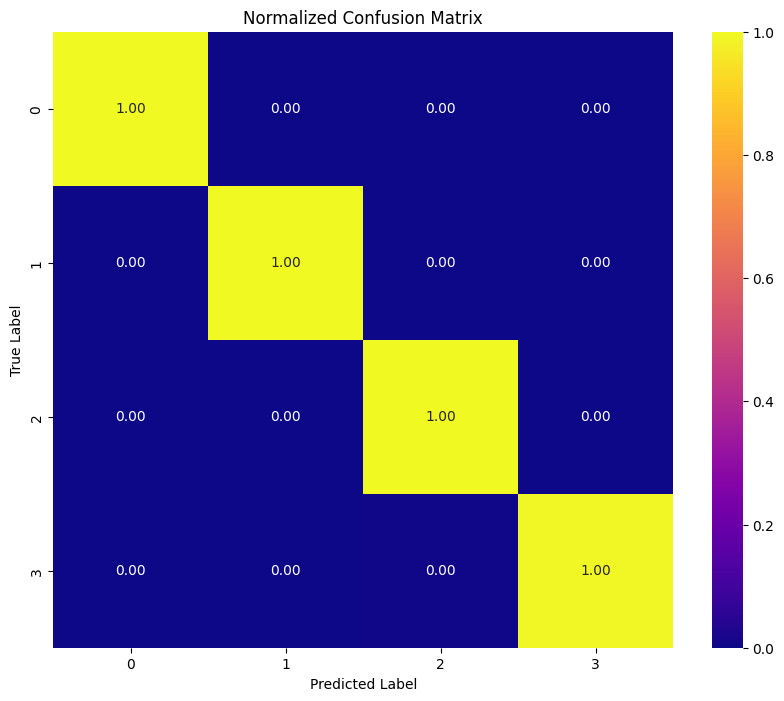

In [30]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

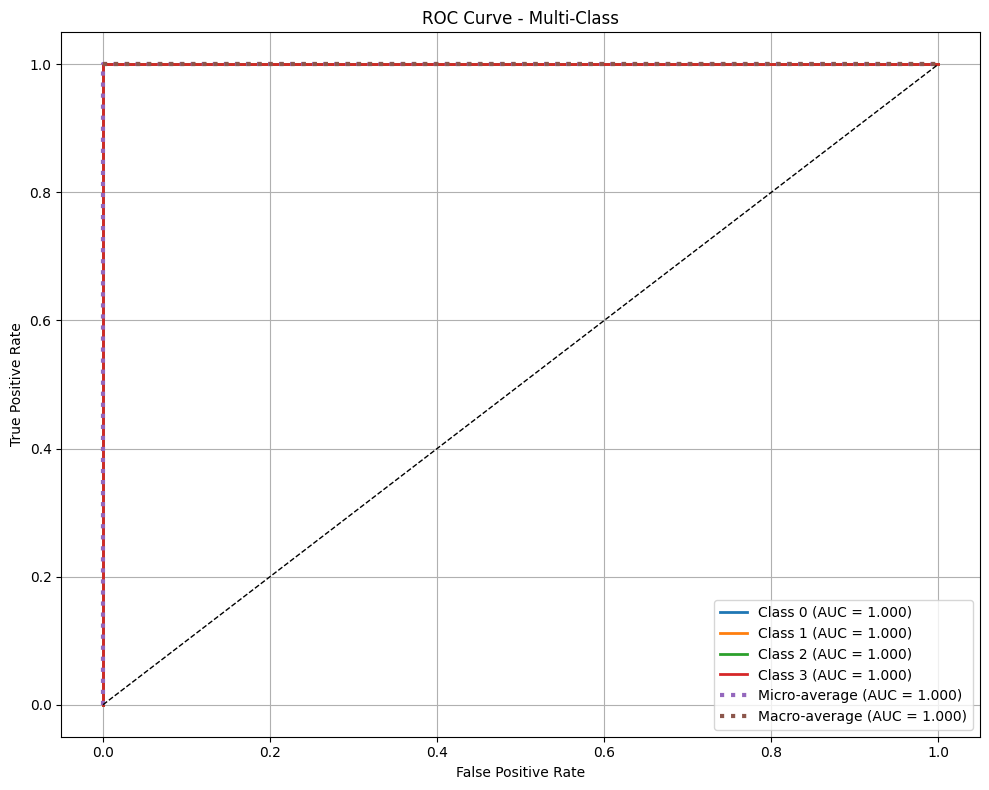

In [31]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()